In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../models/stylegan2')
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as oj
import pickle as pkl
import gan_helper
import torch
import util
import config
import os
GAN = gan_helper.Generator() # initializes gan
print('Done!')

**note - look at some of the plots in `analyze_inn` nb to help with this**

# load latent-mapping model

In [13]:
orth_dict = pkl.load(open(oj(config.PROCESSED_DIR, '02_orth.pkl'), 'rb'))
orth_mat = orth_dict['vecs_orth'].transpose() # make it (512, 6)
offsets = np.array([a[0] for a in orth_dict['intercepts']]).flatten()

def predict(z, orth_mat, offsets):
    '''Return projection onto attribute space
    z is (batch_size, 512)
    '''
    return z @ orth_mat + offsets

def increase(z, orth_mat, attr_index, mult):
    '''Move in direction that increases attribute a
    '''
    z_alt = z + mult * orth_mat[:, attr_index].flatten()    
    print(np.around(z_alt @ orth_mat + offsets, 2))
    return z_alt

def normalize(u):
    return u / np.linalg.norm(u)


def project_to_boundary(z, ws, bs, n_iter=100):
    '''
    Params
    ------
    X: np.ndarray (1, 512)
        point to be projected
    ws: np.ndarray (512, n_attributes)
        coefficients for different linear models
    bs: array_like (n_attributes)
        intercepts for linear model
    '''    
    n_attr = ws.shape[1]

    if n_attr == 1:
        return project_to_plane(z, ws[:, 0], bs[0])

    # Iterative procedure for getting to boundary
    for i in range(n_iter):
        attr_index = i % n_attr
        X = project_to_plane(z, ws[:, attr_index], bs[attr_index])

    return X   

def project_to_plane(z, w, b):
    '''
    Params
    ------
    X: np.ndarray (1, 512)
        point to be projected
    w: np.ndarray (512)
        coefficients for linear model
    b: scalar
        intercept for linear model
    '''
    
    w, b = w.copy(), b.copy()

    # Get and normalize coefficients
    b = b / np.linalg.norm(w)
    w = normalize(w)

    # Project points back to hyperplane, decision value = 0
    d = np.sum(w * z, -1) + b

    return z - w * np.expand_dims(d, 1)
    
# project the image to boundary
# z0 = np.random.randn(1, 512)
# z_new = project_to_boundary(z0, orth_mat, offsets, attr_index=0)

**let's walk in face space (using shared z)**

In [16]:
np.random.seed(4)
z0 = np.random.randn(1, 512) #zeros((1, 512)) #X[1:2] * 0
z0 = GAN.z_to_style(z0)[:, 0, :] # need to pick only first layer
print(z0.shape)
z0 = project_to_boundary(z0, orth_mat, offsets)
z0.shape

(1, 512)


(1, 512)

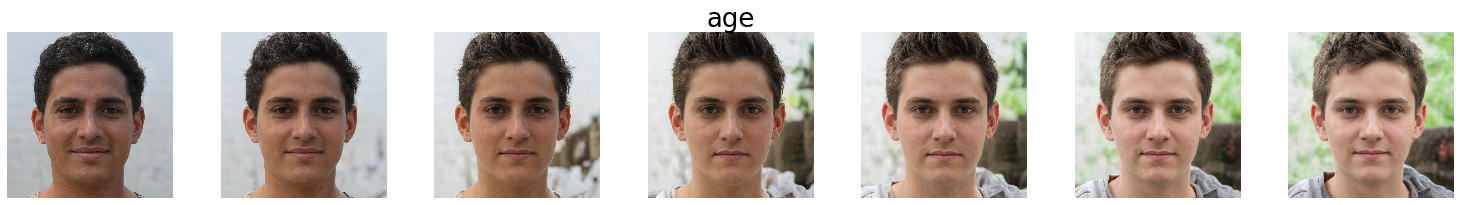

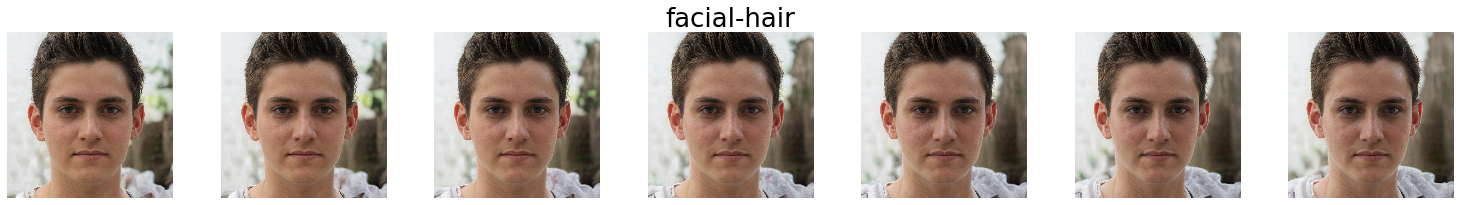

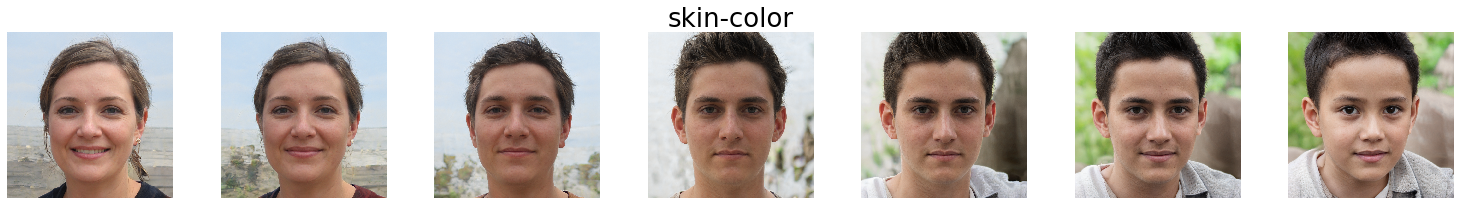

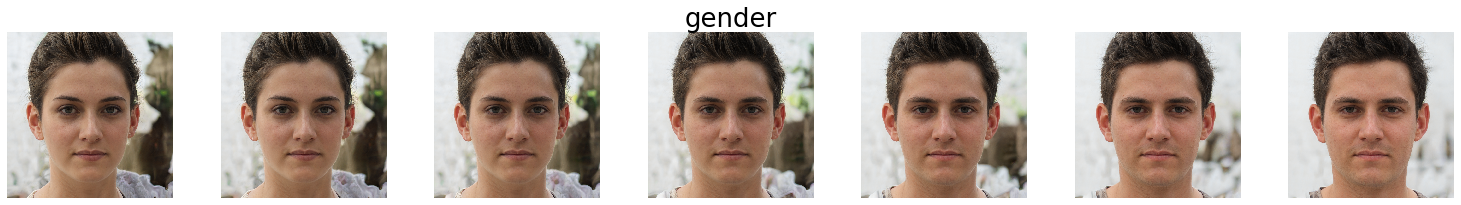

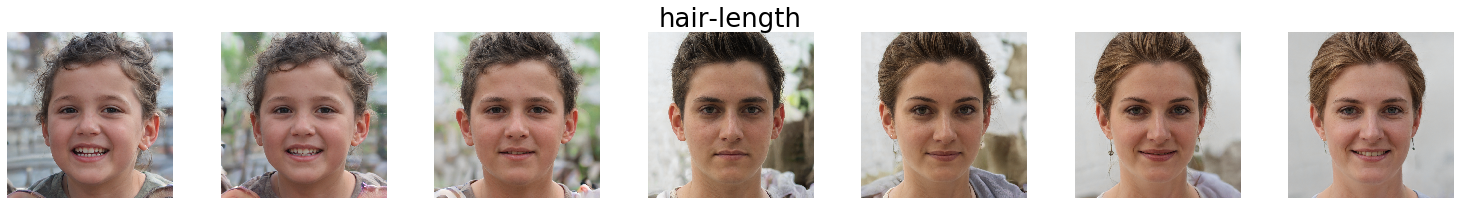

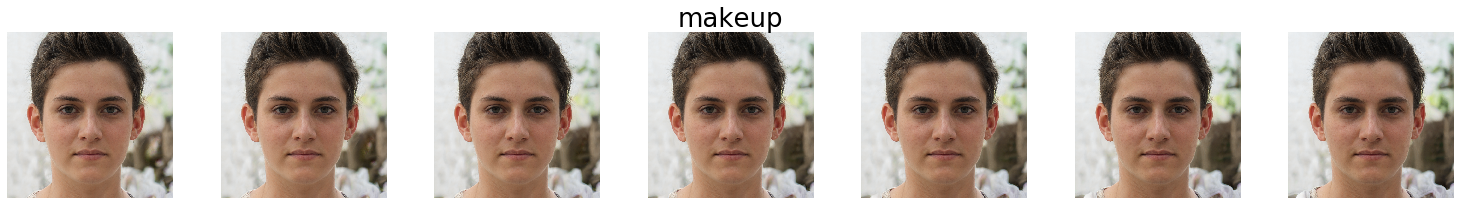

In [17]:
# min/max to vary these attributes
attr_mults = { 
    'age': 1,
    'facial-hair': 2,
    'skin-color': 2.5,
    'gender': 1,
    'hair-length': 1,
    'makeup': 1
}

# z0 = np.random.randn(1, 512) * 0.1
# z0 = project_to_boundary(z0, orth_mat, offsets)
N_IMS = 7 # should be odd
N_ATTR = len(config.ATTRS)
ims = np.zeros((N_IMS, N_ATTR))
for attr_index, attr in enumerate(config.ATTRS):
#     z_new = project_to_plane(z0, orth_mat[:, attr_index], offsets[attr_index])
    zs = np.zeros((N_IMS, 512))
    for j in range(N_IMS):
        diff = j - N_IMS // 2
        zs[j] = project_to_plane(z0, orth_mat[:, attr_index],
                                 offsets[attr_index] + diff * attr_mults[attr])
#         print(np.around(zs[j] @ orth_mat + offsets, 2))
#         print(f'{zs[j] @ orth_mat[:, attr_index] + offsets[attr_index] + diff:0.2f}')
#         zs[j] = increase(z0, orth_mat, attr_index=attr_index, mult=diff * mult)
    images = GAN.gen(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()

# using projected images (full z)

**get a latent from embedding**

In [78]:
fnames = sorted([fname 
          for fname in os.listdir(config.REAL_LATENT_ENCODINGS_DIR)
          if '.npy' in fname])
latents = np.load(oj(config.REAL_LATENT_ENCODINGS_DIR, fnames[1]))
z0 = np.expand_dims(latents, 0)

In [ ]:
# print('z at different scales are not the same')
# viz.corrplot(np.corrcoef(latents))
# plt.colorbar()
# plt.show()

In [ ]:
# im = GAN.gen_full(z0)
# util.imshow(im)

**let's walk in face space**

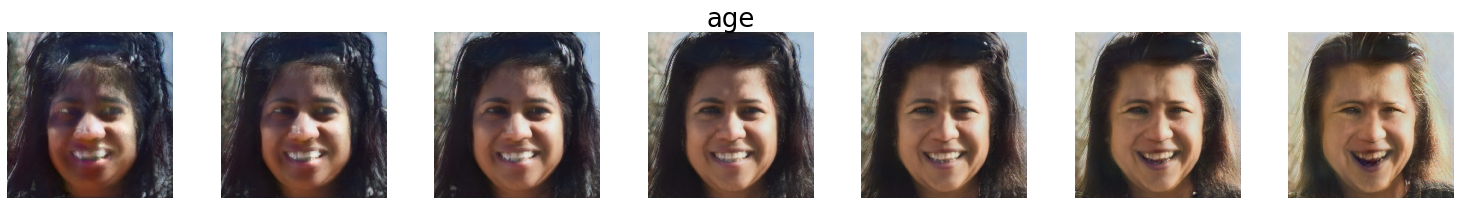

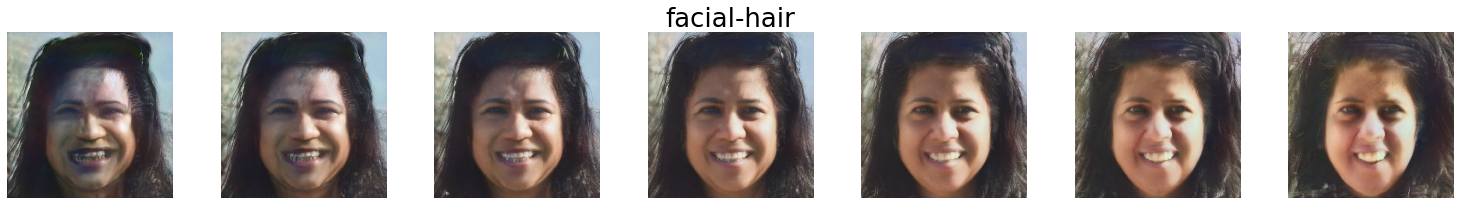

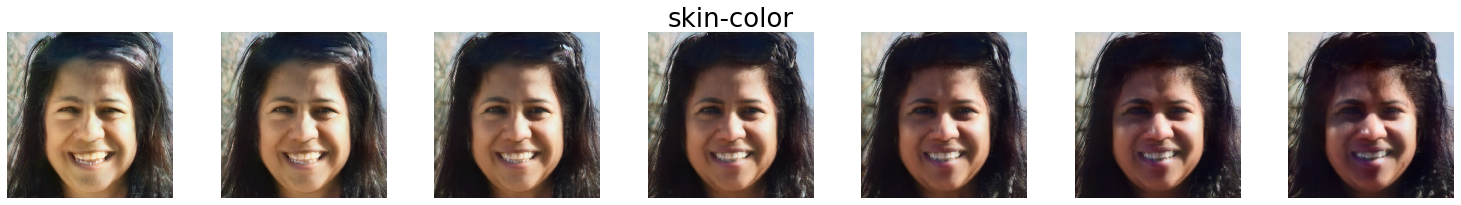

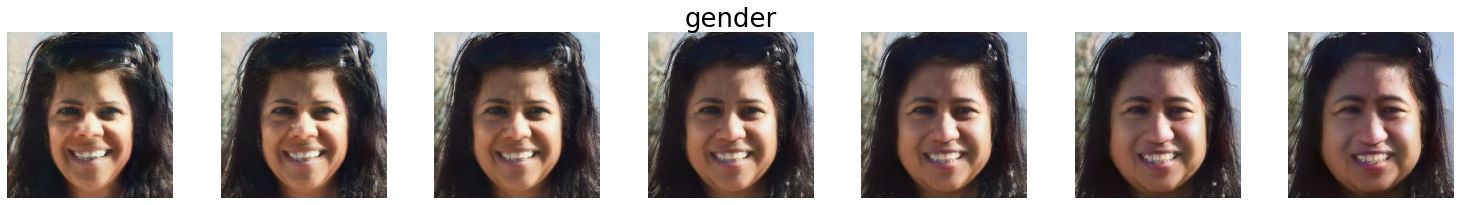

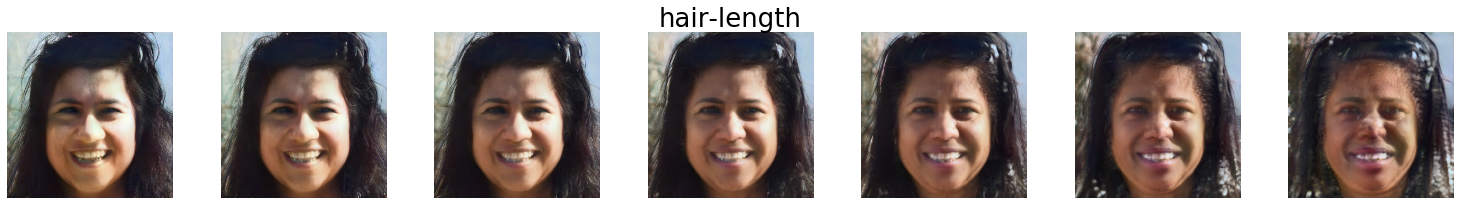

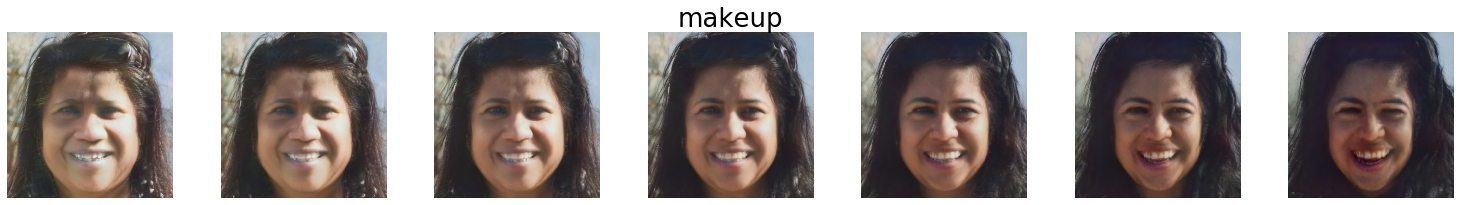

In [88]:
z0 = np.squeeze(z0)
# z0: (18, 512)
N_IMS = 7 # should be odd
MULT = 18
a = m(torch.Tensor(z0))
for attr_index, attr in enumerate(config.ATTRS):
    
    # get a mapping for z0
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 0.05
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
#         a_arr[j * MULT: j * MULT + 17, attr_index] += diff * mult * delta
        a_arr[j * MULT: (j + 1) * MULT, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    zs = zs.reshape(N_IMS, MULT, -1).squeeze()
    images = GAN.gen_full(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()